In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


# Generate a count matrix of random noise

We want our factor model to tell us that this is just noise

In [2]:
N = 5000
D = 20
P = 3

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(3.0, size=(N, D)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)


Currently, the input data has to be in this format, as a tensorflow BatchDataset object with the given key/values.

# Set up the inference object

In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    # encoder_function=lambda x: x, decoder_function=lambda x: x,
    dtype=tf.float64, u_tau_scale=0.01)
# Test to make sure sampling works


Feature dim: 20 -> Latent dim 3


## Test out the prior distributions

In [4]:
## 
sample = factor.joint_prior.sample(10)
# Compute the joint log probability of the sample
probs = factor.joint_prior.log_prob(sample)
sample_surrogate = factor.surrogate_distribution.sample(77)
probs_parts = factor.unormalized_log_prob_parts(
    **sample_surrogate, data=next(iter(data)))
prob = factor.unormalized_log_prob(
    **sample_surrogate,  data=next(iter(data)))



# Inference

In [5]:
losses = factor.calibrate_advi(
    num_epochs=200, rel_tol=1e-10, learning_rate=.1)



W0519 21:32:22.496069 4521491904 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 59.4260473744012
Epoch 1: average-batch loss: 48.65175682786762 last batch loss: 40.102157333804094
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 39.225355035849766 last batch loss: 36.2815262251382
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 35.175552052117986 last batch loss: 34.57853743944902
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 34.037301211699 last batch loss: 33.940561335908754
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 33.94898566918947 last batch loss: 33.79904603492185
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 33.953235649570196 last batch loss: 33.92129036190501
Epoch 7: average-batch loss: 33.88408177763176 last batch loss: 33.753536542823845
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 8: average-batch loss: 33.804088395417644 last batch loss: 33.64855687560819
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 9: average-batch loss: 

Epoch 71: average-batch loss: 33.15244469141545 last batch loss: 33.070587054726765
Saved a checkpoint: ./.tf_ckpts/chkpt-45
Epoch 72: average-batch loss: 33.15534910138964 last batch loss: 33.075701114388664
We are in a loss plateau learning rate: 2.44140625e-05 loss: 33.2117313239504
Restoring from a checkpoint - loss: 33.20995753246058
Epoch 73: average-batch loss: 33.146646483973875 last batch loss: 33.08733738003511
Saved a checkpoint: ./.tf_ckpts/chkpt-46
Epoch 74: average-batch loss: 33.14152253641014 last batch loss: 33.064738824755885
Saved a checkpoint: ./.tf_ckpts/chkpt-47
Epoch 75: average-batch loss: 33.1364049407737 last batch loss: 33.0612161212027
Saved a checkpoint: ./.tf_ckpts/chkpt-48
Epoch 76: average-batch loss: 33.143418245774285 last batch loss: 33.06737296966008
Epoch 77: average-batch loss: 33.14102036510117 last batch loss: 33.05427958596624
Epoch 78: average-batch loss: 33.13811513441337 last batch loss: 33.06680906734582
Epoch 79: average-batch loss: 33.1342

Epoch 141: average-batch loss: 33.03418936689657 last batch loss: 32.96500913458211
Epoch 142: average-batch loss: 33.031814788396126 last batch loss: 32.949494963756315
Epoch 143: average-batch loss: 33.02996484168752 last batch loss: 32.95306782230328
Epoch 144: average-batch loss: 33.03120512978847 last batch loss: 32.953763056846554
Epoch 145: average-batch loss: 33.03630444000845 last batch loss: 32.948776904304935
We are in a loss plateau learning rate: 3.7252902984619143e-10 loss: 33.08332981883982
Restoring from a checkpoint - loss: 33.101230456716166
Epoch 146: average-batch loss: 33.027110646469396 last batch loss: 32.946301554838506
Saved a checkpoint: ./.tf_ckpts/chkpt-78
Epoch 147: average-batch loss: 33.03427906550165 last batch loss: 32.949407733626664
Epoch 148: average-batch loss: 33.025954660175294 last batch loss: 32.956385628627096
Saved a checkpoint: ./.tf_ckpts/chkpt-79
Epoch 149: average-batch loss: 33.029754626546385 last batch loss: 32.94688930603011
Epoch 150:

# Compute the WAIC

In [6]:
waic = factor.waic()
print(waic)

{'waic': 347591.8830061442, 'se': 1422.6741959592628, 'lppd': -38935.274089092665, 'pwaic': 134860.66741397942}


# Plot the factor encoding matrix

In [7]:
intercept_data = az.convert_to_inference_data(
    {
        r"$w_d$": tf.squeeze(
            factor.surrogate_distribution.sample(1000)['w']*factor.norm_factor).numpy().T})

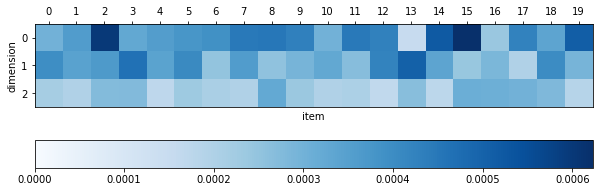

In [8]:
fig, ax = plt.subplots(figsize=(10,4))

plt.imshow(factor.encoding_matrix().numpy().T, vmin=0, cmap="Blues")
plt.xticks(np.arange(D))
ax.set_xlabel("item")
ax.set_ylabel("dimension")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(np.arange(P))
plt.colorbar(orientation = "horizontal")
plt.show()


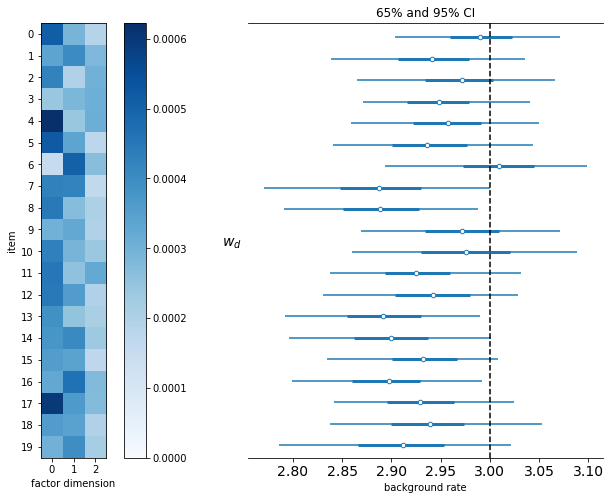

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(3.0, linestyle='dashed', color="black")
plt.savefig('noise_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


The values in the factor encoding matrix as near zero. There is a gradient because the model induces a dimensional decay to remove symmetries - this encourages the leading dimensions to hold more of the signal.